# Tensorflow to Tensorflow Lite

# Currently not working due to bad variables name and cells order

In this notebook, I try to create a simple image recognition network in order to then covert it to TF Lite to compare results.
The original network is tested and saved, with tf.saved_model.save. It is recommended to use this rather than the Keras API when trying to convert the model to TF Lite.
So far, the model is very accurate in the classical version, it works and predicts with the Lite version too. 


Currently it uses a loop to predict the every img of the test set 1 by 1, there must be a more efficient way to do so.

## 1. Tensorflow normal model

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Flatten

#### Model definition

In [6]:
model1 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(320, activation='relu'),
    Dense(160, activation='relu'),
    Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'sgd',
                metrics = 'acc')



#### Data 

In [7]:
df = pd.read_csv('./mnist_data/train.csv')
df_train = df.iloc[:35000] # 35000/42000
df_test2 = df.iloc[35000:] # the 7000 left
df_test= df_test2.drop('label', axis = 1)

# Has the label column
print('test shape : ', df_test.shape)


X = df_train.drop('label', axis = 1)
X /= 255.0 # Normalize
#print(X.loc[0].shape)

# Label of all the images
y = df_train['label']

test shape :  (7000, 784)


#### Model fit

In [8]:
# The nb of epochs doesn't matter much at the moment, at 30 accuracy is at 99% 
model1.fit(X, y, epochs=30)


Epoch 1/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.7324 - acc: 0.8227
Epoch 2/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3285 - acc: 0.9068
Epoch 3/30
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2722 - acc: 0.9219
Epoch 4/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.2385 - acc: 0.9319
Epoch 5/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.2121 - acc: 0.9403
Epoch 6/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1908 - acc: 0.9459
Epoch 7/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1732 - acc: 0.9503
Epoch 8/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1578 - acc: 0.9555
Epoch 9/30
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1450 - acc: 0.9594
Epoch 10/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1334 - acc: 0.9619
Epoch 11/30
1094/1094 [======

In [9]:
ypreds = model1.predict(df_test)
print('ypreds shape :', ypreds.shape)
# ypreds is the prediction result over the test set, using the model1 (normal TF)
# in one-hot format
ypreds

ypreds shape : (7000, 10)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

#### Example plot/verification

5

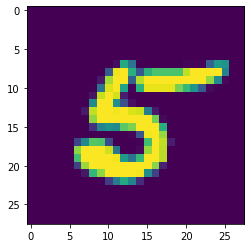

In [10]:
number = df_test.loc[35002].values
number = number.reshape(28,28)
plt.imshow(number)
# a way of returning the only 1 in the 0s array : np.argsort(ypreds[2])[9]
# a much better way
np.argmax(ypreds[2])
# the prediction is correct

### Saving the model
It is saved here because it then easier to see how it re-usable for tflite use, and because the first conversion attempt is with tf.lite.TFLiteConverter.from_saved_model

In [11]:
path = './model1_mnist/'
tf.saved_model.save(model1, path)

INFO:tensorflow:Assets written to: ./model1_mnist/assets


## 2. TFLite model

### First we convert it 

In [12]:
# could use from_keras_model, may not be so much differences
converter = tf.lite.TFLiteConverter.from_saved_model(path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_2']}}


### Then we set up the interpreter
(See TFLite site)

In [13]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#### Attempt to test with the same image as tested with the model network, to compare predictions.

Careful on the input/output shape. As I didn't specify the model signatures, the converter understood the input shape as [1, 784]

Note : the data type 'float32' also come from the signature, and could possibly be changed for optimization. 

In [14]:
print(input_details)
signatures = interpreter.get_signature_list()
print('Signatures =>', signatures)

[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([  1, 784], dtype=int32), 'shape_signature': array([ -1, 784], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Signatures => {'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_2']}}


In [15]:
input_shape = input_details[0]['shape']
print(input_shape)

# Is set to 0 at the beginning
print(interpreter.get_tensor(output_details[0]['index']))

test_img = df_test.loc[35008].values # is a 9 
input_data = np.array(test_img, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data.reshape(1,784))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data) # predicts a 9 too 


[  1 784]
[[-0.2798224   0.28949627 -0.06875481 -0.1014585  -0.03039126  0.26040196
   0.08608792  0.16431718  0.42715    -0.13336818]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4249514e-22
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]


#### Optional : 

In [16]:
# Deprecated 
# Is a 'slow' way to invoke the interpreter on every test image and then create a new result list. 
# Was needed when I didn't know how to change the input shape of the input tensor.
litepreds = []
for j in range(df_test.shape[0]):
    row = df_test.loc[35000+j].values
    inputimg = np.array(row, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], inputimg.reshape(1,784))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    litepreds.append(output_data)

print(litepreds[5])
print(ypreds[5])
truth = np.array(litepreds == ypreds)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [17]:
input_details[0]['index']

0

#### Now I want to run the inference on the whole trainining set and not just one image at each interpreter 'invoke'.
The first step is converting the df to an array of the right data type in order to input it to the tensor

In [18]:
testarray = df_test.to_numpy()
#np.shape(testarray)
testarray = np.array(testarray, dtype=np.float32)

Then I run the predictions on the whole set, efter resizing the input tensor, allocating and loading the new 'testarray' into the the input tensor

In [19]:
interpreter.resize_tensor_input(input_index = input_details[0]['index'],tensor_size=(7000,784))
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], testarray)

interpreter.invoke()

tflite_predictions = interpreter.get_tensor(output_details[0]['index'])

#### Results obtained

In [20]:
#check
np.shape(tflite_predictions)

(7000, 10)

In [21]:
a = np.argmax(tflite_predictions, axis=1)
b = np.argmax(ypreds, axis=1)

# correct labels are on the last column from the df_test2 set, df_test had it dropped for size issues
labels = df_test2.iloc[:,0].values

In [22]:
assert np.shape(a) == np.shape(b) == (7000,) 

Accuracy

In [23]:
(b==labels).mean()

0.9697142857142858

Classical vs lite accuracy, will be 1 if no changes to the data type, meaning we juste have the same model

In [24]:
(a==b).mean()

1.0

In [25]:
interpreter.tensor(output_details[0]['index'])

<function tensorflow.lite.python.interpreter.Interpreter.tensor.<locals>.<lambda>()>

## 3. Quantization
Starting with Post-training integer quantization

In [26]:
# converter2 = tf.lite.TFLiteConverter.from_keras_model(model1)
# converter2.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model_quant = converter2.convert()

The model is now a bit smaller with quantized weights, but other variable data is still in float format.
To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a RepresentativeDatase, a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

In [27]:
# Normalize the input image so that each pixel value is between 0 to 1. (was done earlier in the first model fit)
df_train2 = df_train.astype(np.float32) / 255.0
df_train2 = df_train2.drop('label', axis = 1, errors='ignore')
df_train2 = df_train2.astype(np.float32)
df_test2 = df_test2.astype(np.float32) / 255.0
df_train2.dtypes

pixel0      float32
pixel1      float32
pixel2      float32
pixel3      float32
pixel4      float32
             ...   
pixel779    float32
pixel780    float32
pixel781    float32
pixel782    float32
pixel783    float32
Length: 784, dtype: object

In [28]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(df_train2).batch(1).take(100):
    yield [input_value]

converter2 = tf.lite.TFLiteConverter.from_saved_model(path)
converter2.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 
converter2.inference_input_type = tf.uint8
converter2.inference_output_type = tf.uint8

tflite_model_quant = converter2.convert()

In [29]:
## Quant results : 
interpreter2 = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type_q = interpreter2.get_input_details()[0]['dtype']
print('input: ', input_type_q)
output_type_q = interpreter2.get_output_details()[0]['dtype']
print('output: ', output_type_q)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [30]:

signatures_q = interpreter2.get_signature_list()
print(signatures_q)

{'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_2']}}


In [31]:
interpreter2.allocate_tensors()
input_details_q = interpreter2.get_input_details()[0]
output_details_q = interpreter2.get_output_details()[0]

input_details_q # we can see the dtype changed to uint8 and the quantization parameters and settings

{'name': 'serving_default_flatten_input:0',
 'index': 0,
 'shape': array([  1, 784], dtype=int32),
 'shape_signature': array([ -1, 784], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.003921568859368563, 0),
 'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [32]:
testarray2 = df_test.to_numpy()
#np.shape(testarray)
testarray2 = np.array(testarray2, dtype=np.uint8)

In [33]:
output_details_q

{'name': 'StatefulPartitionedCall:0',
 'index': 14,
 'shape': array([ 1, 10], dtype=int32),
 'shape_signature': array([-1, 10], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.00390625, 0),
 'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [34]:
np.shape(testarray2)
#testarray2[0]

(7000, 784)

In [35]:
if input_details_q['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details_q["quantization"]
    test_img1 =  testarray2[5]
    test_img1 = test_img1 / input_scale + input_zero_point
testarray2 = testarray2 / input_scale
testarray2 = testarray2 + input_zero_point

In [36]:
#interpreter2.resize_tensor_input(input_index = input_details_q[0]['index'],tensor_size=(7000,784))
interpreter2.allocate_tensors()

test_img1 = test_img1.astype(input_details_q["dtype"])
interpreter2.set_tensor(0, test_img1.reshape(1,784))

interpreter2.invoke()

tflite_predictions_quant = interpreter2.get_tensor(14)

In [37]:
input_details_q

{'name': 'serving_default_flatten_input:0',
 'index': 0,
 'shape': array([  1, 784], dtype=int32),
 'shape_signature': array([ -1, 784], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.003921568859368563, 0),
 'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

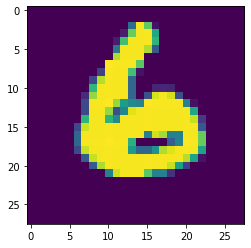

In [38]:
test_img1
testarray2[5]

testarray0 = testarray2[5]
testarray0 = testarray0.reshape(28,28)
test_img1 = test_img1.reshape(28,28)
plt.imshow(testarray0)
#plt.imshow(test_img1)

In [39]:
np.shape(tflite_predictions_quant)

(1, 10)

In [40]:
pred = np.argmax(tflite_predictions_quant)
pred

6

In [41]:
# Whole test
testarray2 = np.array(testarray2, dtype=np.uint8)
interpreter2.resize_tensor_input(0,tensor_size=(7000,784))
interpreter2.allocate_tensors()

interpreter2.set_tensor(0, testarray2)

interpreter2.invoke()

tflite_predictions_quant2 = interpreter2.get_tensor(14)


In [42]:
c = np.argmax(tflite_predictions_quant2, axis=1)
assert np.shape(a) == np.shape(b) == (7000,) 


print('Quantized model accuracy :',(c==labels).mean() )
print('Classic model accuracy:', (b==labels).mean() )

Quantized model accuracy : 0.5912857142857143
Classic model accuracy: 0.9697142857142858


In [43]:
np.shape(tflite_predictions_quant2)

(7000, 10)